In [62]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random, time
from sklearn.metrics import accuracy_score

import requests, zipfile, io
import os, glob
import shutil

print(tf.__version__)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2.9.1


In [52]:
seq_length = 100
BUFFER_SIZE = 10000
embedding_dim = 256
rnn_units = 1024
BATCH_SIZE = 64
EPOCHS = 500
PATIENCE = 10
MONITOR = 'acc'

In [35]:
# data_dir = './data/shakespeare_char_based/'
# if not os.path.exists(data_dir):
#     os.makedirs(data_dir)

path_to_file = tf.keras.utils.get_file(os.path.join('shakespeare.txt'), 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

print(os.listdir('C:\\Users\\yazee\\.keras\\datasets\\.'))
print(path_to_file)

# with open(path_to_file) as file:
#     text = file.read()
    
with open(path_to_file, 'rb') as file:
    text = file.read().decode(encoding='utf-8')
    
print(f'Length of text: {len(text)} characters')

vocab = sorted(set(text))
print(f'{len(vocab)} unique characters\n\n')

print(text[:250])

['boston_housing.npz', 'fashion-mnist', 'shakespeare.txt']
C:\Users\yazee\.keras\datasets\shakespeare.txt
Length of text: 1115394 characters
65 unique characters


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [36]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
ids = ids_from_chars(chars)
print('ids =', ids)


chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
chars = chars_from_ids(ids)
print('chars =', chars)

# this will reduce them back into a single string
print(tf.strings.reduce_join(chars, axis=-1).numpy())

ids = <tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>
chars = <tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>
[b'abcdefg' b'xyz']


In [37]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

for ids in ids_dataset.take(12):
    print(chars_from_ids(ids).numpy().decode('utf-8'), end='')

First Citize

In [38]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
    print(chars_from_ids(seq), end='')
print('\n\n')
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy(), end='')

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou 'b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be 

In [39]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [55]:
dataset = sequences.map(split_input_target)

for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())
    
train_dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
vocab_size = len(ids_from_chars.get_vocabulary())

train_dataset, vocab_size

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


(<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>,
 66)

In [53]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x
        
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

model.compile(
    optimizer='adam', 
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)
# model.summary()

In [47]:
# for input_example_batch, target_example_batch in dataset.take(1):
#     example_batch_predictions = model(input_example_batch)
#     print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

# sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
# sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
# print(sampled_indices)

# print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
# print()
# print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Epoch 1/500
170/172 [============================>.] - ETA: 0s - loss: 1.9871 - acc: 0.4194

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 1.9852 - acc: 0.4199 - lr: 0.0010
Epoch 2/500
171/172 [============================>.] - ETA: 0s - loss: 1.7029 - acc: 0.4943

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 1.7023 - acc: 0.4945 - lr: 0.0010
Epoch 3/500
170/172 [============================>.] - ETA: 0s - loss: 1.5397 - acc: 0.5377

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 1.5393 - acc: 0.5378 - lr: 0.0010
Epoch 4/500
171/172 [============================>.] - ETA: 0s - loss: 1.4410 - acc: 0.5628

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 1.4406 - acc: 0.5629 - lr: 0.0010
Epoch 5/500
172/172 [==============================] - ETA: 0s - loss: 1.3731 - acc: 0.5799

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 34ms/step - loss: 1.3731 - acc: 0.5799 - lr: 0.0010
Epoch 6/500
172/172 [==============================] - ETA: 0s - loss: 1.3210 - acc: 0.5931

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 1.3210 - acc: 0.5931 - lr: 0.0010
Epoch 7/500
170/172 [============================>.] - ETA: 0s - loss: 1.2769 - acc: 0.6039

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 34ms/step - loss: 1.2770 - acc: 0.6039 - lr: 0.0010
Epoch 8/500
172/172 [==============================] - ETA: 0s - loss: 1.2360 - acc: 0.6143

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 1.2360 - acc: 0.6143 - lr: 0.0010
Epoch 9/500
170/172 [============================>.] - ETA: 0s - loss: 1.1954 - acc: 0.6256

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 1.1958 - acc: 0.6255 - lr: 0.0010
Epoch 10/500
172/172 [==============================] - ETA: 0s - loss: 1.1559 - acc: 0.6361

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 1.1559 - acc: 0.6361 - lr: 0.0010
Epoch 11/500
172/172 [==============================] - ETA: 0s - loss: 1.1148 - acc: 0.6477

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 1.1148 - acc: 0.6477 - lr: 0.0010
Epoch 12/500
171/172 [============================>.] - ETA: 0s - loss: 1.0720 - acc: 0.6604

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 1.0723 - acc: 0.6603 - lr: 0.0010
Epoch 13/500
171/172 [============================>.] - ETA: 0s - loss: 1.0257 - acc: 0.6743

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 1.0259 - acc: 0.6742 - lr: 0.0010
Epoch 14/500
172/172 [==============================] - ETA: 0s - loss: 0.9766 - acc: 0.6895

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.9766 - acc: 0.6895 - lr: 0.0010
Epoch 15/500
170/172 [============================>.] - ETA: 0s - loss: 0.9264 - acc: 0.7055

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.9268 - acc: 0.7053 - lr: 0.0010
Epoch 16/500
172/172 [==============================] - ETA: 0s - loss: 0.8747 - acc: 0.7221

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.8747 - acc: 0.7221 - lr: 0.0010
Epoch 17/500
170/172 [============================>.] - ETA: 0s - loss: 0.8224 - acc: 0.7389

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.8229 - acc: 0.7387 - lr: 0.0010
Epoch 18/500
172/172 [==============================] - ETA: 0s - loss: 0.7716 - acc: 0.7555

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.7716 - acc: 0.7555 - lr: 0.0010
Epoch 19/500
172/172 [==============================] - ETA: 0s - loss: 0.7243 - acc: 0.7705

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.7243 - acc: 0.7705 - lr: 0.0010
Epoch 20/500
170/172 [============================>.] - ETA: 0s - loss: 0.6797 - acc: 0.7855

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.6802 - acc: 0.7852 - lr: 0.0010
Epoch 21/500
171/172 [============================>.] - ETA: 0s - loss: 0.6413 - acc: 0.7976

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 34ms/step - loss: 0.6416 - acc: 0.7975 - lr: 0.0010
Epoch 22/500
172/172 [==============================] - ETA: 0s - loss: 0.6072 - acc: 0.8084

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.6072 - acc: 0.8084 - lr: 0.0010
Epoch 23/500
171/172 [============================>.] - ETA: 0s - loss: 0.5762 - acc: 0.8181

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.5765 - acc: 0.8180 - lr: 0.0010
Epoch 24/500
169/172 [============================>.] - ETA: 0s - loss: 0.5502 - acc: 0.8256

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.5511 - acc: 0.8252 - lr: 0.0010
Epoch 25/500
170/172 [============================>.] - ETA: 0s - loss: 0.5298 - acc: 0.8314

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.5306 - acc: 0.8311 - lr: 0.0010
Epoch 26/500
172/172 [==============================] - ETA: 0s - loss: 0.5141 - acc: 0.8358

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.5141 - acc: 0.8358 - lr: 0.0010
Epoch 27/500
171/172 [============================>.] - ETA: 0s - loss: 0.4958 - acc: 0.8415

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.4961 - acc: 0.8414 - lr: 0.0010
Epoch 28/500
171/172 [============================>.] - ETA: 0s - loss: 0.4820 - acc: 0.8452

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.4823 - acc: 0.8450 - lr: 0.0010
Epoch 29/500
170/172 [============================>.] - ETA: 0s - loss: 0.4741 - acc: 0.8469

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.4749 - acc: 0.8466 - lr: 0.0010
Epoch 30/500
170/172 [============================>.] - ETA: 0s - loss: 0.4664 - acc: 0.8481

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.4671 - acc: 0.8479 - lr: 0.0010
Epoch 31/500
170/172 [============================>.] - ETA: 0s - loss: 0.4563 - acc: 0.8513

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.4570 - acc: 0.8510 - lr: 0.0010
Epoch 32/500
170/172 [============================>.] - ETA: 0s - loss: 0.4495 - acc: 0.8530

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.4501 - acc: 0.8528 - lr: 0.0010
Epoch 33/500
172/172 [==============================] - ETA: 0s - loss: 0.4411 - acc: 0.8556

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.4411 - acc: 0.8556 - lr: 0.0010
Epoch 34/500
172/172 [==============================] - 3s 17ms/step - loss: 0.4397 - acc: 0.8551 - lr: 0.0010
Epoch 35/500
170/172 [============================>.] - ETA: 0s - loss: 0.4353 - acc: 0.8564

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.4360 - acc: 0.8561 - lr: 0.0010
Epoch 36/500
172/172 [==============================] - ETA: 0s - loss: 0.4338 - acc: 0.8565

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.4338 - acc: 0.8565 - lr: 0.0010
Epoch 37/500
172/172 [==============================] - 4s 17ms/step - loss: 0.4338 - acc: 0.8557 - lr: 0.0010
Epoch 38/500
171/172 [============================>.] - ETA: 0s - loss: 0.4283 - acc: 0.8574

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.4287 - acc: 0.8573 - lr: 0.0010
Epoch 39/500
171/172 [============================>.] - ETA: 0s - loss: 0.4246 - acc: 0.8586

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.4249 - acc: 0.8584 - lr: 0.0010
Epoch 40/500
172/172 [==============================] - 4s 17ms/step - loss: 0.4246 - acc: 0.8579 - lr: 0.0010
Epoch 41/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4248 - acc: 0.8579 - lr: 0.0010
Epoch 42/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4258 - acc: 0.8570 - lr: 0.0010
Epoch 43/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4268 - acc: 0.8561 - lr: 0.0010
Epoch 44/500
169/172 [============================>.] - ETA: 0s - loss: 0.4183 - acc: 0.8590

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.4193 - acc: 0.8586 - lr: 0.0010
Epoch 45/500
169/172 [============================>.] - ETA: 0s - loss: 0.4167 - acc: 0.8596

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.4178 - acc: 0.8592 - lr: 0.0010
Epoch 46/500
172/172 [==============================] - 4s 17ms/step - loss: 0.4211 - acc: 0.8579 - lr: 0.0010
Epoch 47/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4240 - acc: 0.8563 - lr: 0.0010
Epoch 48/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4237 - acc: 0.8564 - lr: 0.0010
Epoch 49/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4263 - acc: 0.8551 - lr: 0.0010
Epoch 50/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4303 - acc: 0.8536 - lr: 0.0010
Epoch 51/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4328 - acc: 0.8530 - lr: 0.0010
Epoch 52/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4347 - acc: 0.8524 - lr: 0.0010
Epoch 53/500
172/172 [==============================] - 3s 16ms/step - loss: 0.4297 - acc: 0.8540 - lr: 0.0010
Epoch 54/500
1

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.3254 - acc: 0.8938 - lr: 1.0000e-04
Epoch 57/500
169/172 [============================>.] - ETA: 0s - loss: 0.2352 - acc: 0.9347

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 34ms/step - loss: 0.2351 - acc: 0.9346 - lr: 1.0000e-04
Epoch 58/500
172/172 [==============================] - ETA: 0s - loss: 0.1989 - acc: 0.9522

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1989 - acc: 0.9522 - lr: 1.0000e-04
Epoch 59/500
172/172 [==============================] - ETA: 0s - loss: 0.1781 - acc: 0.9617

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.1781 - acc: 0.9617 - lr: 1.0000e-04
Epoch 60/500
171/172 [============================>.] - ETA: 0s - loss: 0.1636 - acc: 0.9670

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1636 - acc: 0.9670 - lr: 1.0000e-04
Epoch 61/500
169/172 [============================>.] - ETA: 0s - loss: 0.1528 - acc: 0.9704

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1529 - acc: 0.9704 - lr: 1.0000e-04
Epoch 62/500
169/172 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9725

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.1443 - acc: 0.9724 - lr: 1.0000e-04
Epoch 63/500
171/172 [============================>.] - ETA: 0s - loss: 0.1374 - acc: 0.9736

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1374 - acc: 0.9736 - lr: 1.0000e-04
Epoch 64/500
171/172 [============================>.] - ETA: 0s - loss: 0.1314 - acc: 0.9746

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.1314 - acc: 0.9746 - lr: 1.0000e-04
Epoch 65/500
170/172 [============================>.] - ETA: 0s - loss: 0.1263 - acc: 0.9753

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1263 - acc: 0.9752 - lr: 1.0000e-04
Epoch 66/500
171/172 [============================>.] - ETA: 0s - loss: 0.1218 - acc: 0.9757

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1219 - acc: 0.9756 - lr: 1.0000e-04
Epoch 67/500
172/172 [==============================] - ETA: 0s - loss: 0.1179 - acc: 0.9760

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 34ms/step - loss: 0.1179 - acc: 0.9760 - lr: 1.0000e-04
Epoch 68/500
172/172 [==============================] - ETA: 0s - loss: 0.1145 - acc: 0.9762

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1145 - acc: 0.9762 - lr: 1.0000e-04
Epoch 69/500
169/172 [============================>.] - ETA: 0s - loss: 0.1113 - acc: 0.9764

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 34ms/step - loss: 0.1114 - acc: 0.9764 - lr: 1.0000e-04
Epoch 70/500
172/172 [==============================] - ETA: 0s - loss: 0.1086 - acc: 0.9765

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1086 - acc: 0.9765 - lr: 1.0000e-04
Epoch 71/500
170/172 [============================>.] - ETA: 0s - loss: 0.1060 - acc: 0.9765

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.1061 - acc: 0.9765 - lr: 1.0000e-04
Epoch 72/500
169/172 [============================>.] - ETA: 0s - loss: 0.1037 - acc: 0.9766

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1037 - acc: 0.9766 - lr: 1.0000e-04
Epoch 73/500
170/172 [============================>.] - ETA: 0s - loss: 0.1017 - acc: 0.9766

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.1017 - acc: 0.9766 - lr: 1.0000e-04
Epoch 74/500
171/172 [============================>.] - ETA: 0s - loss: 0.0998 - acc: 0.9766

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 33ms/step - loss: 0.0999 - acc: 0.9766 - lr: 1.0000e-04
Epoch 75/500
170/172 [============================>.] - ETA: 0s - loss: 0.0982 - acc: 0.9766

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.0982 - acc: 0.9766 - lr: 1.0000e-04
Epoch 76/500
172/172 [==============================] - 4s 17ms/step - loss: 0.0966 - acc: 0.9766 - lr: 1.0000e-04
Epoch 77/500
171/172 [============================>.] - ETA: 0s - loss: 0.0952 - acc: 0.9767

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.0952 - acc: 0.9767 - lr: 1.0000e-04
Epoch 78/500
172/172 [==============================] - 4s 17ms/step - loss: 0.0938 - acc: 0.9766 - lr: 1.0000e-04
Epoch 79/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0926 - acc: 0.9766 - lr: 1.0000e-04
Epoch 80/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0915 - acc: 0.9766 - lr: 1.0000e-04
Epoch 81/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0904 - acc: 0.9766 - lr: 1.0000e-04
Epoch 82/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0895 - acc: 0.9766 - lr: 1.0000e-04
Epoch 83/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0885 - acc: 0.9765 - lr: 1.0000e-04
Epoch 84/500
169/172 [============================>.] - ETA: 0s - loss: 0.0843 - acc: 0.9778

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 31ms/step - loss: 0.0842 - acc: 0.9778 - lr: 1.0000e-05
Epoch 85/500
172/172 [==============================] - ETA: 0s - loss: 0.0829 - acc: 0.9778

INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


INFO:tensorflow:Assets written to: ./models\NLP_CHAR_PROG\assets


172/172 [==============================] - 6s 32ms/step - loss: 0.0829 - acc: 0.9778 - lr: 1.0000e-05
Epoch 86/500
172/172 [==============================] - 4s 17ms/step - loss: 0.0823 - acc: 0.9778 - lr: 1.0000e-05
Epoch 87/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0819 - acc: 0.9777 - lr: 1.0000e-05
Epoch 88/500
172/172 [==============================] - 4s 17ms/step - loss: 0.0816 - acc: 0.9777 - lr: 1.0000e-05
Epoch 89/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0814 - acc: 0.9777 - lr: 1.0000e-05
Epoch 90/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0812 - acc: 0.9776 - lr: 1.0000e-05
Epoch 91/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0810 - acc: 0.9776 - lr: 1.0000e-05
Epoch 92/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0809 - acc: 0.9775 - lr: 1.0000e-05
Epoch 93/500
172/172 [==============================] - 3s 16ms/step - loss: 0.0807 - acc: 0.

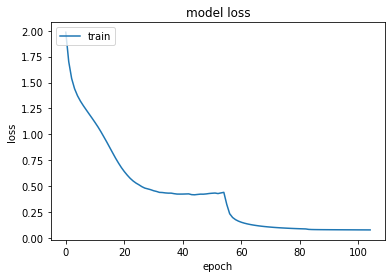

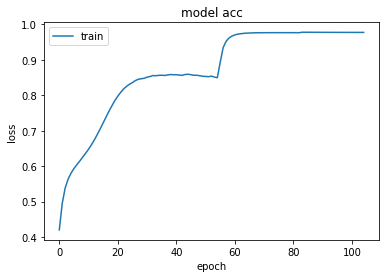

In [59]:
MODEL_NAME = './models/NLP_CHAR_PROG'

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint( MODEL_NAME, save_format="tf", monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    # validation_data=test_dataset,
    callbacks=callbacks
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states,
                                              return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "[UNK]" from being generated.
        predicted_logits = tf.cast(predicted_logits, tf.float16) + tf.cast(self.prediction_mask, tf.float16)

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)

        # Return the characters and model state.
        return predicted_chars, states
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [71]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
The exchange of thy love's faithful vow for mine.

JULIET:
I gave thee mine before thou didst ventur'
To have drawn mad with thee from this place.

CAMILLO:
He that you have done with thee?

GRUMIO:
Nay, sit down; he that know it not this castle;
Where should she bid me make the leave?
Is this the foe is mine, and tell my case,
For their own victory, captain, who lets
express thee. O heavens! Spoke to!
And look to bed. What was my blood awding,
And let the sufficient cold scraff and Edward's blood:
Besides, upon the coronation.

POMPEY:
No, good father.

DUKE VINCENTIO:
let the warrant's cousin!
Thy mother rather fear of Warwick affords and great
As all the climate should entreat Edward's shame,
Unless thy suit of mine order lives again,
And since thou hast mildled with his king,
Was match's nothing like the night of fortune's sea,
So ean my ease the adult cheer eports
his enemies in my sheep-shall marry success?
And forfeit into despair and a holy man.
Rays, treason will I woul

In [72]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThe effect of nothing traitor\nTo bless the sea shed nobleness.\n\nCOMINIUS:\nOnce do this, but Romeo here, here comes and leave you.\n\nKING EDWARD IV:\nHe says so, Tybalt is not a stranger\nAnd leave the growt shice--'Stand, Kate, come away.\n\nPROSPERO:\nNo, will your guider here writ.\n\nJULIET:\nI saw the wounds that stabb'd dishonour from his face\nBy any likelihood down their will:\nWouldst have me weep? why, she will comfort that are\nnecessity, that we lap to land of\nWould will afford fly is not whipt under grief,\nWhich tenderly to the English crown,\nAnd then dreams here look on note of my sword,\nThat to the last with thee that lies in with our heads,\nFor his bond ago I might be son: between\nAnd shine to pleade your worship dead spirits\nAnd see home arm: and live was death o'er your latest,\nWhen I shall all dear according to visiting his.\n\nJOHN OF GAUNT:\nWhat, lovel! and a king, bleed!\nLook you his thanks that you do crave that plaged my life,

In [73]:
tf.saved_model.save(one_step_model, './models/NLP_CHAR_PROG_one_step')
one_step_reloaded = tf.saved_model.load('./models/NLP_CHAR_PROG_one_step')

states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

INFO:tensorflow:Assets written to: ./models/NLP_CHAR_PROG_one_step\assets


INFO:tensorflow:Assets written to: ./models/NLP_CHAR_PROG_one_step\assets


ROMEO:
The exchange of thy love's faithful vow for mine.

JULIET:
I was; his worthy sedumnusty, and mine.

